# Assignment 3 - Sparse matrices -- ZIJIN SU 22085664

##  Introduction

This notebook investigates how to implement custom sparse matrix operators using SciPy’s LinearOperator framework. In Part 1, i will construct a CSR matrix from a COO input, implement addition and matrix–vector multiplication, validate these operations through tests, and compare their performance with NumPy’s dense routines and SciPy’s iterative solvers. In Part 2, i will define a special block-structured matrix with a low-rank dense component, implement an efficient matvec for this structure, and analyse its computational performance against standard dense/sparse formats.

In [42]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import scipy
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import coo_matrix as coo
from scipy.sparse import csr_matrix
import logging
import sys
import timeit

## Part 1: Implementing a CSR matrix

In [43]:
# stage log setting for better adjusting potential error
def setup_logger(level=logging.INFO):
    """Configure root logger formatting"""
    fmt = "%(asctime)s - %(levelname)s - %(name)s - %(message)s"
    handler = logging.StreamHandler(sys.stdout)
    handler.setFormatter(logging.Formatter(fmt))
    logger = logging.getLogger("CSR")   
    logger.handlers[:] = [handler]
    logger.setLevel(level)
    return logger
logger = setup_logger(logging.INFO)

In [44]:
class CSRMatrix(LinearOperator):
    def __init__(self, coo_matrix):
        """to obatin a CSRmatrix from coo_matrix input"""
        if not isinstance(coo_matrix, coo):
            logger.error('CSR matrix initialization failed: %s', type(coo_matrix))
            raise TypeError("coomatrix need to be scipy coomatrix")

        logger.info("initialising csrmatrix from coomatrix with shape %s", coo_matrix.shape)

        # check bug
        coo_matrix._check()
        logger.debug("coo matrix check passed")

        # check row of coomarix,[:-1] element must <= [:1] element in the matrix
        if len(coo_matrix.data) == 0 or np.all(coo_matrix.row[:-1] <= coo_matrix.row[1:]):
            logger.info("coomatrix rows already sorted or empty")
            row = coo_matrix.row
            col = coo_matrix.col
            data = coo_matrix.data
        else:
            order = np.lexsort((coo_matrix.col, coo_matrix.row))
            row = coo_matrix.row[order]
            col = coo_matrix.col[order]
            data = coo_matrix.data[order]

        # Store basic CSR attributes
        self.shape = coo_matrix.shape          # (num_rows, num_cols) of the matrix
        self.dtype = coo_matrix.dtype          # Data type of the matrix entries
        self.data = data                       # Non-zero values in CSR format
        self.indices = col                     # Column indices corresponding to each entry in `data`

        # Allocate indptr array of length (num_rows + 1)
        # indptr[i] gives the starting index of row i in `data` and `indices`
        self.indptr = np.zeros(self.shape[0] + 1, dtype=row.dtype)

        logger.debug("Allocated CSR arrays: data=%d entries, rows=%d", len(data), self.shape[0])

        # count the number of the row
        for row_index in row:
            self.indptr[row_index + 1] += 1
        self.indptr = np.cumsum(self.indptr)

        logger.info(f"CSRMatrix built: data={len(self.data)}, indptr={len(self.indptr)}")

    def __add__(self, other):
        """Add the CSR matrix other to this matrix."""
        # check shape
        if self.shape != other.shape:
            logger.error("shape differ (self =%s, other =%s)", self.shape, other.shape)
            raise ValueError("CSR matrix need to be same shape")

        m, n = self.shape

        # Convert self from CSR to coo
        self_diff = np.diff(self.indptr)
        self_row = np.repeat(range(m), self_diff)

        # Convert other from CSR to coo
        other_diff = np.diff(other.indptr)
        other_row = np.repeat(range(m), other_diff)

        # Combine entries
        row = np.concatenate([self_row, other_row])
        col = np.concatenate([self.indices, other.indices])
        data = np.concatenate([self.data, other.data])

        # Build COO and merge duplicates
        out_coo = coo((data, (row, col)), shape=self.shape)
        out_nnz_before = out_coo.nnz #number of nonzero value
        out_coo.sum_duplicates()
        out_nnz_after = out_coo.nnz
        logger.info("COO duplicate merge: before=%d, after=%d", out_nnz_before, out_nnz_after)

        # Convert back to CSRMatrix
        logger.info("CSRMatrix addition completed with %d nonzero entries.", out_nnz_after)
        return CSRMatrix(out_coo)


    def _matvec(self, vector):
        """Compute y = A @ vector using CSR structure."""
        # Output vector
        y = np.zeros(self.shape[0], dtype=self.dtype)
        # CSR traversal
        for row in range(self.shape[0]):
            start = self.indptr[row]
            end = self.indptr[row + 1]
            y[row] = np.dot(self.data[start:end], vector[self.indices[start:end]])

        return y


In [45]:
# create two random coomatrix
A = scipy.sparse.random(4, 4, density=0.3)
A_coo = coo(A)
B = scipy.sparse.random(4, 4, density=0.3)
B_coo = coo(B)
# scipy result
C = A_coo + B_coo
C_dense = C.toarray()
# using CSRMatrix convert coomatrix to csrmatrix
A_csr = CSRMatrix(A_coo)
B_csr = CSRMatrix(B_coo)
# test __add__
C_csr = A_csr.__add__(B_csr)
# CSRMatrix to numpy array
C_csr_add = csr_matrix(
    (C_csr.data, 
    C_csr.indices.astype(np.int32),
    C_csr.indptr.astype(np.int32)),
    shape=A_coo.shape
).toarray()
print("C (scipy) =\n", C_dense)
print("C (__add__)  =\n", C_csr_add)
assert np.allclose(C_dense, C_csr_add)
# test matvec 
x = np.random.rand(4)
y_true = A @ x      # scipy result
y_test = A_csr.matvec(x)          # matvec result
print("\nmatvec check (A @ x):")
print("scipy =", y_true)
print("result =", y_test)
assert np.allclose(y_true, y_test)
print("all test passed")

2025-11-19 12:10:21,763 - INFO - CSR - initialising csrmatrix from coomatrix with shape (4, 4)
2025-11-19 12:10:21,764 - INFO - CSR - CSRMatrix built: data=5, indptr=5
2025-11-19 12:10:21,780 - INFO - CSR - initialising csrmatrix from coomatrix with shape (4, 4)
2025-11-19 12:10:21,780 - INFO - CSR - CSRMatrix built: data=5, indptr=5
2025-11-19 12:10:21,781 - INFO - CSR - COO duplicate merge: before=10, after=8
2025-11-19 12:10:21,781 - INFO - CSR - CSRMatrix addition completed with 8 nonzero entries.
2025-11-19 12:10:21,781 - INFO - CSR - initialising csrmatrix from coomatrix with shape (4, 4)
2025-11-19 12:10:21,782 - INFO - CSR - coomatrix rows already sorted or empty
2025-11-19 12:10:21,782 - INFO - CSR - CSRMatrix built: data=8, indptr=5
C (scipy) =
 [[0.         1.76951715 0.         0.        ]
 [0.17269286 0.         0.         0.5845476 ]
 [0.90751528 0.76330764 0.46428291 0.        ]
 [0.53858892 0.         0.9647088  0.        ]]
C (__add__)  =
 [[0.         1.76951715 0.   

## Measure the time cost of two methods

testing density = 0.01
2025-11-19 12:10:21,828 - INFO - CSR - initialising csrmatrix from coomatrix with shape (1, 1)
2025-11-19 12:10:21,829 - INFO - CSR - coomatrix rows already sorted or empty
2025-11-19 12:10:21,829 - INFO - CSR - CSRMatrix built: data=0, indptr=2
2025-11-19 12:10:21,829 - INFO - CSR - initialising csrmatrix from coomatrix with shape (2, 2)
2025-11-19 12:10:21,830 - INFO - CSR - coomatrix rows already sorted or empty
2025-11-19 12:10:21,830 - INFO - CSR - CSRMatrix built: data=0, indptr=3
2025-11-19 12:10:21,831 - INFO - CSR - initialising csrmatrix from coomatrix with shape (7, 7)
2025-11-19 12:10:21,831 - INFO - CSR - coomatrix rows already sorted or empty
2025-11-19 12:10:21,831 - INFO - CSR - CSRMatrix built: data=0, indptr=8
2025-11-19 12:10:21,832 - INFO - CSR - initialising csrmatrix from coomatrix with shape (21, 21)
2025-11-19 12:10:21,832 - INFO - CSR - CSRMatrix built: data=4, indptr=22
2025-11-19 12:10:21,833 - INFO - CSR - initialising csrmatrix from c

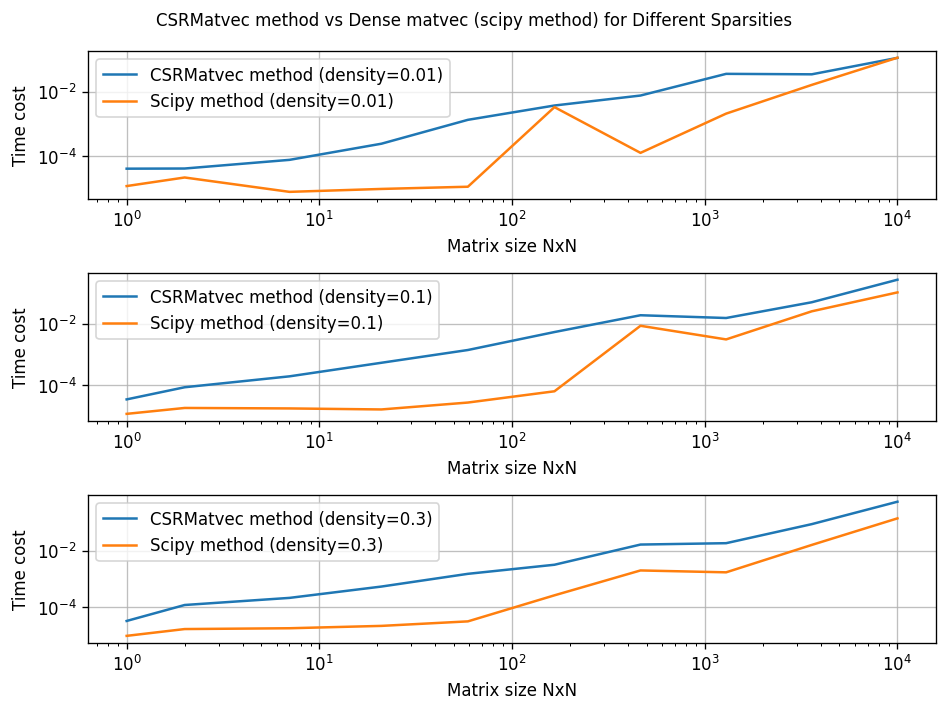

In [46]:
# #Timing validation
N_list = np.logspace(0,4,10,dtype=int)
#define repeat time
N_repeat = 10
# define sparsities tht will be use for demonstrate different performance
densities = [0.01, 0.1, 0.3]
#create empty matrix to store timing information
times_matvec = [[] for _ in densities]
times_sci  = [[] for _ in densities]

for d_i, density in enumerate(densities):
    print(f"testing density = {density}")
    for N in N_list:
        #first create a coo matrix
        A_coo = scipy.sparse.random(N, N, density=density, format = 'coo')
        #correspond dense version
        A_dense = A_coo.toarray()
        #convert to csr matrix again
        A_csr = CSRMatrix(A_coo)
        #use random vector
        x = np.random.rand(N)
        # time CSRMatrix method
        t_csr = timeit.timeit(lambda: A_csr.matvec(x), number=N_repeat)
        times_matvec[d_i].append(t_csr)

        # time scipy dense method
        t_sci = timeit.timeit(lambda: A_dense @ x, number=N_repeat)
        times_sci[d_i].append(t_sci)


#plotting for comparison
fig,ax = plt.subplots(3,1,figsize=(8,6),dpi = 120)
for i,density in enumerate(densities):
    ax[i].plot(N_list,times_matvec[i],"-",label = f"CSRMatvec method (density={density})")
    ax[i].plot(N_list,times_sci[i],"-",label = f"Scipy method (density={density})")
    ax[i].set_xlabel("Matrix size NxN")
    ax[i].set_ylabel("Time cost")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].minorticks_on()
    ax[i].legend()
    ax[i].grid(True,alpha = 0.8)

fig.suptitle("CSRMatvec method vs Dense matvec (scipy method) for Different Sparsities",fontsize=10)
plt.tight_layout()
plt.show()

This plot show a clear trend in how the two matrix–vector multiplication methods behave as both the matrix size and sparsity change. For very sparse matrices (density = 0.01), the CSR-based matvec consistently outperforms the dense NumPy method across almost all sizes. This is expected, since the number of non-zero entries is extremely small, and the CSR format avoids unnecessary operations on zeros. As the density increases, the performance gap between the two methods increases. For density = 0.01 and especially 0.3, the advantage of CSR becomes less pronounced, and for larger matrices the dense NumPy implementation can become faster. This is mainly due to NumPy’s highly optimised low-level routines, which benefit from vectorisation and parallel execution, while the CSR implementation here relies on explicit Python loops. Overall, CSR matvec is more efficient when the matrix is sufficiently sparse, whereas dense methods become competitive or superior as the number of non-zero entries grows.

## cg and gmres comparison (For a matrix of your choice and a random vector, use Scipy’s gmres and cg sparse solvers to solve a matrix problem using your CSR matrix. Check if the two solutions obtained are the same.)

2025-11-19 12:12:40,515 - INFO - CSR - initialising csrmatrix from coomatrix with shape (20, 20)
2025-11-19 12:12:40,516 - INFO - CSR - coomatrix rows already sorted or empty
2025-11-19 12:12:40,518 - INFO - CSR - CSRMatrix built: data=400, indptr=21


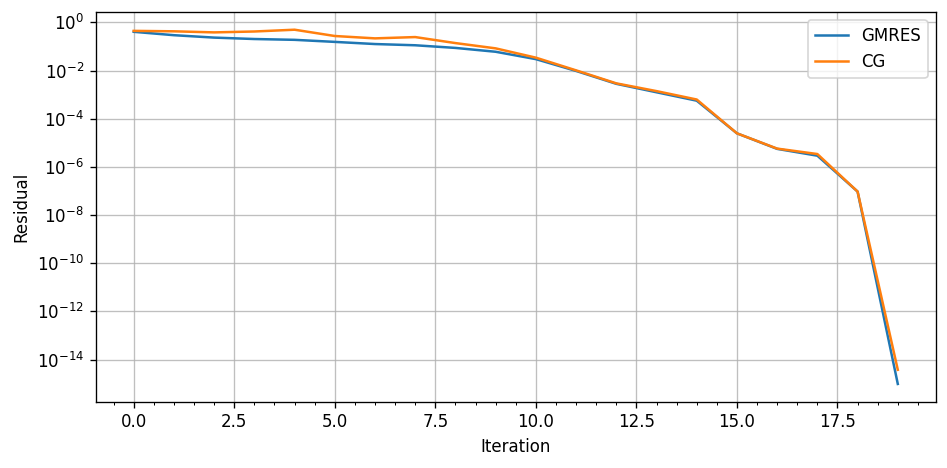

All close : True
Exactly the same : False
Relative difference equal to 2.5608317526063877e-15


In [78]:
# construct symmetric positive-definite matrix
size = 20
# Generate a random orthogonal matrix Q using QR decomposition
Q, _ = np.linalg.qr(np.random.randn(size, size))
# Create a diagonal matrix with random positive entries
D = np.diag(np.random.rand(size))
# Construct a symmetric matrix A = Q_T D Q (diagonalizable with eigenvalues from D matrix)
A = coo(Q.T @ D @ Q)
b = np.random.rand(size)
A_csr_solv = CSRMatrix(A)
# record residuals
gmres_residuals = []
cg_residuals = []

def gmres_callback(resid):
    gmres_residuals.append(resid)

def cg_callback(xk):
    r = b - A @ xk
    cg_residuals.append(np.linalg.norm(r) / np.linalg.norm(b))

# solve using cg and gmres
sol_gm, info_gm = scipy.sparse.linalg.gmres(
    A_csr_solv, b,
    callback=gmres_callback,
    callback_type='legacy',
    rtol=1e-10,
    maxiter=1000
)

sol_cg, info_cg = scipy.sparse.linalg.cg(
    A_csr_solv, b,
    callback=cg_callback,
    rtol=1e-10,
    maxiter=1000
)

# plot residuals
plt.figure(figsize=(8,4), dpi=120)
plt.plot(gmres_residuals, label="GMRES")
plt.plot(cg_residuals, label="CG")
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.minorticks_on()
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.tight_layout()
plt.show()

# compare solutions
print("All close", np.allclose(sol_gm, sol_cg)) # ensure results are the same
print("Exactly the same", np.array_equal(sol_gm, sol_cg))
rel_diff = np.linalg.norm(sol_gm - sol_cg, np.inf) / np.linalg.norm(sol_gm, np.inf) # calculate the actual numercial difference
print("Relative difference equal to", rel_diff)

The solutions obtained from GMRES and CG are not exactly equal to one another and can be adjusted within a tolarence range(1e-15). This difference arises because both solvers use distinct iterative numerical schemes rather than an exact analytical method, and each method converges along a different path. Despite producing slightly different outputs, both solvers achieve solutions whose residuals fall below the specified tolerance, which is confirmed by the True result from the allclose() check. 

## Part 2 Implementing a custom matrix

In [79]:
class CUSTMatrix(LinearOperator):
    def __init__(self, diag, T, W):
        # store matrix size
        self.n = len(diag)
        self.diag = diag    # top-left diagonal block
        self.Tmat = T          # part of bottom-right block
        self.Wmat = W          # part of bottom-right block

        #operator shape and dtype
        self.shape = (2*self.n, 2*self.n)
        self.dtype = float

    def _matvec(self, x):
        # split input vector to x = [x1; x2]
        x1 = x[:self.n]
        x2 = x[self.n:]
        # compute top block: D * x1
        y1 = self.diag * x1
        # compute bottom block: (T @ W) @ x2 = T @ (W @ x2)
        y2 = self.Tmat @ (self.Wmat @ x2)
        return np.concatenate([y1, y2])

For a range of values of n, create matrices where the entries on the diagonal of the top-left block and in the matrices T and W are random numbers. For each of these matrices, compute matrix-vector products using your implementation and measure the time taken to compute these.

In [92]:
N_test = np.logspace(1,4,10,dtype='int64') #[20, 50, 100, 200, 500, 800, 1000]
times_cust = []
times_dense = []
for N in N_test:
    # construct block components
    diag = np.random.rand(N)
    T = np.random.rand(N, 2)
    W = np.random.rand(2, N)
    # build custom operator
    A_cust = CUSTMatrix(diag, T, W)
    # build explicit dense matrix for comparison
    A_dense = np.zeros((2*N, 2*N))
    A_dense[:N, :N] = np.diag(diag)
    A_dense[N:, N:] = T @ W  # this is O(N^2)
    # random vector
    x = np.random.rand(2*N)
    # measure custom operator time
    t1 = timeit.timeit(lambda: A_cust.matvec(x), number=10)
    times_cust.append(t1)
    # measure dense matrix time
    t2 = timeit.timeit(lambda: A_dense @ x, number=10)
    times_dense.append(t2) 

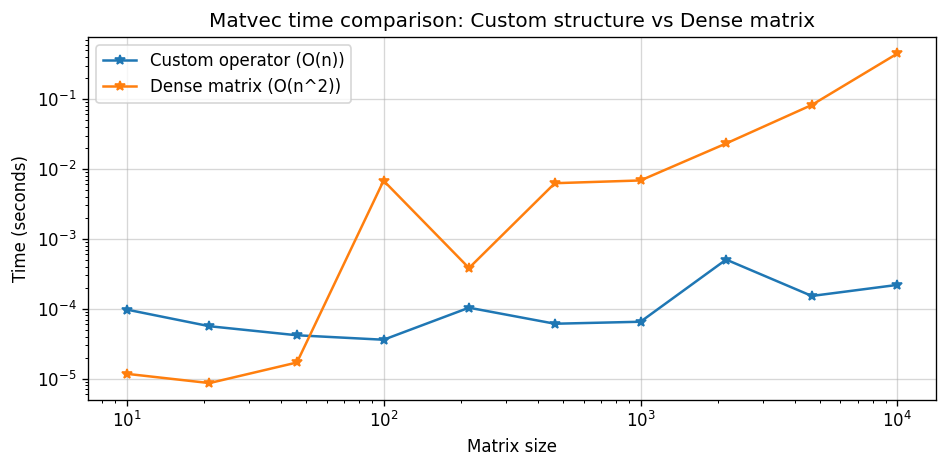

In [93]:
#plot
plt.figure(figsize=(8,4), dpi=120)
plt.plot(N_test, times_cust, "-*", label="Custom operator (O(n))")
plt.plot(N_test, times_dense, "-*", label="Dense matrix (O(n^2))")
plt.xlabel("Matrix size")
plt.ylabel("Time (seconds)")
plt.xscale("log")
plt.yscale("log")
plt.grid(alpha=0.5)
plt.minorticks_on()
plt.legend()
plt.title("Matvec time comparison: Custom structure vs Dense matrix")

plt.tight_layout()
plt.show()

For small values of $n$, the dense NumPy matrix–vector product is faster because it calls highly optimised BLAS routines written in C, while the custom LinearOperator performs several Python-level operations, and this overhead dominates when $n$ is small.
As $n$ grows larger, computational complexity becomes the dominant factor.
The dense method requires $O(n^2)$ operations, since it multiplies a full $n\times n$ block.
In contrast, the custom implementation exploits the structure of the bottom-right block and computes
$,\tilde{A}x = T(Wx),$
in only $O(n)$ time.
Therefore, for sufficiently large $n$, the custom matvec becomes significantly faster than the dense approach, because it avoids forming or multiplying a full dense block and instead uses two low-rank matrices.